In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import random
import time
import os
import math
import matplotlib
from tqdm import trange
from pylab import normal
import matplotlib.ticker as ticker

# TEN-ARMED Bandit Testbed

In [2]:
seed_val = 1
np.random.seed(seed_val)

In [3]:
class NArmedBandit:
    
    #10-armed bandit testbed with sample averages 
    def __init__(self,k=10,step_size = 0.1,eps = 0,UCB_c = None, sample_avg_flag = False,is_stationary = True,
                 init_estimates = 0.0,mu = 0, std_dev = 1, nsteps = 0):
        self.k = k
        self.step_size = step_size
        self.eps = eps
        self.init_estimates = init_estimates
        self.mu = mu
        self.std_dev = std_dev
        self.actions = np.zeros(k)
        self.true_reward = 0.0
        self.UCB_c = UCB_c
        self.nsteps = nsteps
        self.sample_avg_flag = sample_avg_flag
        self.is_stationary = is_stationary
        self.re_init()
        
        
    def re_init(self):
        
        #true values of rewards for each action
        self.actions = np.random.normal(self.mu,self.std_dev,self.k) 
        #self.actions = np.asarray([0.01]*10)

        # estimation for each action
        self.Q_t = np.zeros(self.k) + self.init_estimates

        # num of chosen times for each action
        self.N_t = np.zeros(self.k)

        #best action chosen
        self.optim_action = np.argmax(self.actions)

        self.time_step = 0
        
    
    
    def changeArms(self,ch_mu = 0, ch_std = 0.01):
        #true value of rewards changes every step with increment taken from a distribution (mu=0,std = 0.01)
        for i in range(self.k):
            walk_step = normal(ch_mu,ch_std)
            self.actions[i] = self.actions[i] + walk_step

            #update best action chosen
        self.optim_action = np.argmax(self.actions)

        
    
    def act(self):
        val = np.random.rand()
        if val < self.eps:
            A_t = np.random.choice(np.arange(self.k))
            #print('action 1:',A_t)
        elif self.UCB_c is not None:
            #1e-5 is added so as to avoid division by zero
            ucb_estimates = self.Q_t + self.UCB_c * np.sqrt(np.log(self.time_step + 1) / (self.N_t + 1e-5))
            max_estim = np.max(ucb_estimates)
            A_t = np.random.choice(np.where(ucb_estimates == max_estim)[0])
        else:
            max_estim = np.max(self.Q_t)
            A_t = np.random.choice(np.where(self.Q_t == max_estim)[0])
            #print('action 2:',A_t)
        return A_t
    
    
    
    def step(self,action):
        
        # generating the reward under N(real reward, 1)
        reward = np.random.randn() + self.actions[action]
        self.time_step += 1
        self.N_t[action] += 1
        

        # estimation with sample averages
        if self.sample_avg_flag == True:
            self.Q_t[action] += (reward - self.Q_t[action]) / self.N_t[action]
        else:
            # non-staationary with constant step size 
            self.Q_t[action] += self.step_size * (reward - self.Q_t[action])
            
        return reward
    
    
    def play(self,tasks,num_time_steps):
        rewards = np.zeros((tasks, num_time_steps))
        optim_action_counts = np.zeros(rewards.shape)
        for task in trange(tasks):
            self.re_init()
            for t in range(num_time_steps):
                action = self.act()
                reward = self.step(action)
                rewards[task, t] = reward
                if action == self.optim_action:
                    optim_action_counts[task, t] = 1
                if not self.is_stationary:
                    self.changeArms(ch_mu = 0, ch_std = 0.01)
        avg_optim_action_counts = optim_action_counts.mean(axis=0)*100
        avg_rewards = rewards.mean(axis=0)
        return avg_optim_action_counts, avg_rewards

In [4]:
def fig_2_3(epsilons,tasks, num_time_steps, step_szie = 0.1, UCB_c = None, sample_avg_flag = False,is_stationary = True, nsteps = 0):
    eps_results = {}
    for eps in epsilons: 
        print('running for eps : ', eps)
        eps_results[eps] = {}
        if eps == 0.0:
            bandit = NArmedBandit(k=10, step_size = step_szie, eps = eps, UCB_c = UCB_c, sample_avg_flag = False, 
                                  is_stationary = is_stationary, init_estimates = 5.0,mu = 0, std_dev = 1,nsteps = nsteps)
        elif eps == 0.1:
            bandit = NArmedBandit(k=10, step_size = step_szie, eps = eps, UCB_c = UCB_c, sample_avg_flag = False, 
                                  is_stationary = is_stationary, init_estimates = 0.0,mu = 0, std_dev = 1,nsteps = nsteps)
        avg_optim_action_counts,avg_rewards = bandit.play(tasks=tasks,num_time_steps = num_time_steps)
        eps_results[eps]['Optim_Action_Counts'] = avg_optim_action_counts#avg_rewards#avg_optim_action_counts
        #eps_results[eps]['Average_Rewards'] = avg_rewards
        
    
    
    #if plot_opt_cnt == True:
    fig, ax = plt.subplots()
    for eps in epsilons:
        if eps == 0.0:
            ax.plot(eps_results[eps]['Optim_Action_Counts'],label ='optimistic, greedy, ' + r'$\epsilon$' + ' = {:.01f}, Q1 = {}' .format(eps,5))
        elif eps == 0.1:
            ax.plot(eps_results[eps]['Optim_Action_Counts'],label ='realistic, ' + r'$\epsilon$' + '-greedy, ' + r'$\epsilon$' + ' = {:.01f}, Q1 = {}' .format(eps,0))
    ax.set_xlabel('Steps')
    ax.set_ylabel('% Optimal Action')
    if is_stationary:
        ax.set_title('Optimistic greedy vs. ' + r'$\epsilon$' + '-greedy for Stationary')
    else:
        ax.set_title('Optimistic greedy vs. ' + r'$\epsilon$' + '-greedy for Non-Stationary')
    ax.legend(frameon=True)
    ax.yaxis.set_major_formatter(ticker.PercentFormatter())
    plt.show()
    

In [5]:
def part4(bandit_types,tasks, num_time_steps, step_szie = 0.1, UCB_c = None, sample_avg_flag = False,is_stationary = True,nsteps = 0):
    bandit_results = {}
    for bandit_type in bandit_types: 
        print('running for bandit_type : ', bandit_type)
        bandit_results[bandit_type] = {}
        if bandit_type == 'UCB':
            bandit = NArmedBandit(k=10, step_size = step_szie, eps = 0.0, UCB_c = UCB_c, sample_avg_flag = sample_avg_flag, 
                                  is_stationary = is_stationary,init_estimates = 0.0,mu = 0, std_dev = 1,nsteps = nsteps)
        elif bandit_type == 'Optimistic':
            bandit = NArmedBandit(k=10, step_size = step_szie, eps = 0.0, UCB_c = None, sample_avg_flag = sample_avg_flag, 
                                  is_stationary = is_stationary, init_estimates = 5.0,mu = 0, std_dev = 1,nsteps = nsteps)
        elif bandit_type == 'E-greedy':
            bandit = NArmedBandit(k=10, step_size = step_szie, eps = 0.1, UCB_c = None, sample_avg_flag = sample_avg_flag, 
                                  is_stationary = is_stationary,init_estimates = 0.0,mu = 0, std_dev = 1,nsteps = nsteps)
        avg_optim_action_counts,avg_rewards = bandit.play(tasks=tasks,num_time_steps = num_time_steps)
        bandit_results[bandit_type]['Optim_Action_Counts'] = avg_optim_action_counts
        bandit_results[bandit_type]['Average_Rewards'] = avg_rewards
    
    
    #if plot_opt_cnt == True:
    title = ''
    for bandit_type in bandit_types: 
        if bandit_type == 'UCB':
            title += 'UCB'
            plt.plot(bandit_results[bandit_type]['Average_Rewards'],label = 'UCB c = {}' .format(UCB_c))
        elif bandit_type == 'Optimistic':
            title += ' vs Optimistic'
            plt.plot(bandit_results[bandit_type]['Average_Rewards'],label ='optimistic, greedy, ' + r'$\epsilon$' + '= {:.01f}, Q1 = {}' .format(0.0,5))
        elif bandit_type == 'E-greedy':
            title += ' vs' + r'$\epsilon$' + '-greedy'
            plt.plot(bandit_results[bandit_type]['Average_Rewards'],label = r'$\epsilon-greedy, \epsilon$' + ' = {:.01f}' .format(0.1))
    if is_stationary:
        title += ' for Stationary'
    else:
        title += ' for Non-Stationary'
    plt.xlabel('Steps')
    plt.ylabel('Average Reward')
    plt.title(title)
    plt.legend(frameon=True)
    plt.show()
    
    
    title = ''
    fig, ax = plt.subplots()
    for bandit_type in bandit_types: 
        if bandit_type == 'UCB':
            title += 'UCB'
            ax.plot(bandit_results[bandit_type]['Optim_Action_Counts'],label = 'UCB c = {}' .format(UCB_c))
        elif bandit_type == 'Optimistic':
            title += ' vs Optimistic'
            ax.plot(bandit_results[bandit_type]['Optim_Action_Counts'],label ='optimistic, greedy, ' + r'$\epsilon$' + ' = {:.01f}, Q1 = {}' .format(0.0,5))
        elif bandit_type == 'E-greedy':
            title += ' vs ' + r'$\epsilon$' + '-greedy'
            ax.plot(bandit_results[bandit_type]['Optim_Action_Counts'],label = r'$\epsilon-greedy, \epsilon$' + ' = {:.01f}' .format(0.1))
    if is_stationary:
        title += ' for Stationary'
    else:
        title += ' for Non-Stationary'
    ax.set_xlabel('Steps')
    ax.set_ylabel('% Optimal Action')
    ax.set_title(title)
    ax.legend(frameon=True)
    ax.yaxis.set_major_formatter(ticker.PercentFormatter())
    plt.show()
    

  0%|          | 0/2000 [00:00<?, ?it/s]

starting 10 Armed Bandits play
running for bandit_type :  UCB


  0%|          | 1/2000 [00:00<06:01,  5.53it/s]

running for bandit_type :  Optimistic


100%|██████████| 2000/2000 [05:29<00:00,  6.54it/s]


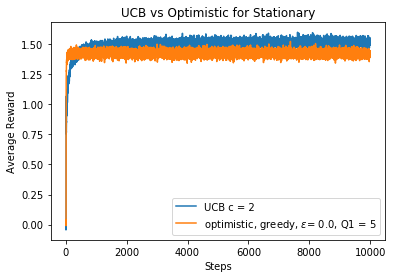

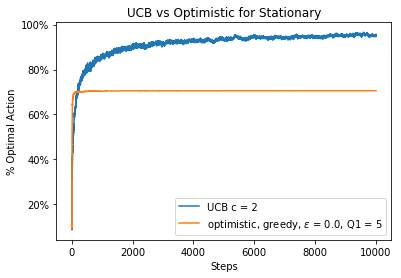

  0%|          | 0/2000 [00:00<?, ?it/s]

running for bandit_type :  UCB


  0%|          | 0/2000 [00:00<?, ?it/s]

running for bandit_type :  Optimistic


100%|██████████| 2000/2000 [11:58<00:00,  2.79it/s]


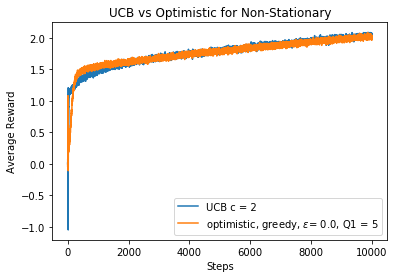

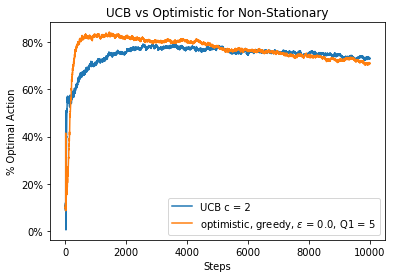

  0%|          | 0/2000 [00:00<?, ?it/s]

running for bandit_type :  UCB


  0%|          | 1/2000 [00:00<04:18,  7.73it/s]

running for bandit_type :  E-greedy


100%|██████████| 2000/2000 [04:22<00:00,  7.76it/s]


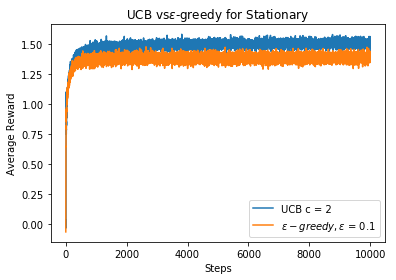

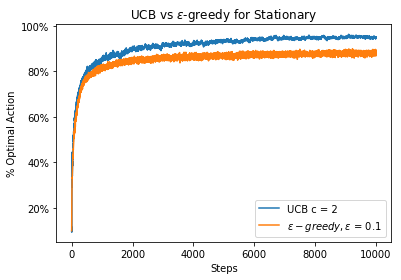

  0%|          | 0/2000 [00:00<?, ?it/s]

running for bandit_type :  UCB


  0%|          | 0/2000 [00:00<?, ?it/s]

running for bandit_type :  E-greedy


100%|██████████| 2000/2000 [11:43<00:00,  2.86it/s]


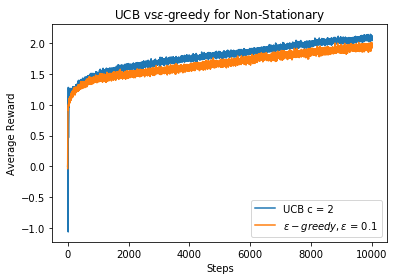

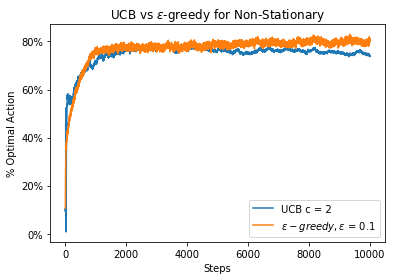

  0%|          | 0/2000 [00:00<?, ?it/s]

running for bandit_type :  UCB


  0%|          | 1/2000 [00:00<05:19,  6.25it/s]

running for bandit_type :  Optimistic


  0%|          | 1/2000 [00:00<04:16,  7.81it/s]

running for bandit_type :  E-greedy


100%|██████████| 2000/2000 [04:17<00:00,  7.85it/s]


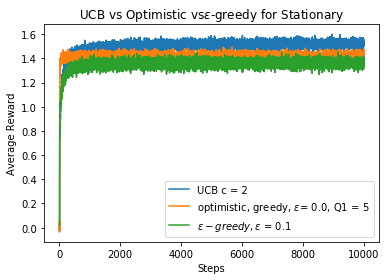

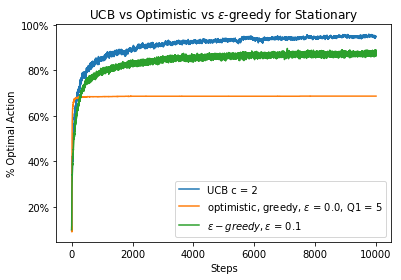

  0%|          | 0/2000 [00:00<?, ?it/s]

running for bandit_type :  UCB


  0%|          | 0/2000 [00:00<?, ?it/s]

running for bandit_type :  Optimistic


  0%|          | 0/2000 [00:00<?, ?it/s]

running for bandit_type :  E-greedy


100%|██████████| 2000/2000 [11:44<00:00,  2.84it/s]


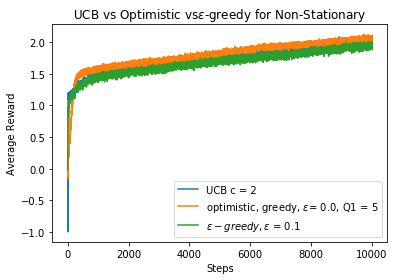

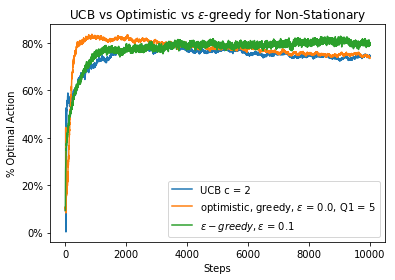

In [7]:
if __name__=='__main__':
    print('starting 10 Armed Bandits play')
    tasks = 2000#1#2000
    num_time_steps = 10000#3000#1000#3000#1000#3000#1000#3000#1000
    epsilons = [0,0.1]
    #playNArmedVBandit(epsilons,tasks, num_time_steps, step_size = 0.1, UCB_c = None, sample_avg_flag = True, 
    #                  init_estimates = 0.0, plot_avg_rew = False, plot_opt_cnt = True)
    #stationary 
    #fig_2_3(epsilons,tasks, num_time_steps, step_szie = 0.1)
    #non-stationary
    #fig_2_3(epsilons,tasks, num_time_steps, step_szie = 0.1,is_stationary = False)
    
    ####part 4 
    bandit_types = ['UCB','Optimistic']
    #stationary
    #part4(bandit_types,tasks, num_time_steps, step_szie = 0.1, UCB_c = 2, sample_avg_flag = True)
    #non-stationary
    #part4(bandit_types,tasks, num_time_steps, step_szie = 0.1, UCB_c = 2, sample_avg_flag = False,is_stationary = False)
    part4(bandit_types,tasks, num_time_steps, step_szie = 0.1, UCB_c = 2, sample_avg_flag = False,is_stationary = False,nsteps = 1000)
    
    bandit_types = ['UCB','E-greedy']
    #stationary
    #part4(bandit_types,tasks, num_time_steps, step_szie = 0.1, UCB_c = 2, sample_avg_flag = True)
    #non-stationary
    #part4(bandit_types,tasks, num_time_steps, step_szie = 0.1, UCB_c = 2, sample_avg_flag = False,is_stationary = False)
    #part4(bandit_types,tasks, num_time_steps, step_szie = 0.1, UCB_c = 2, sample_avg_flag = False,is_stationary = False,nsteps = 1000)
    
    bandit_types = ['UCB','Optimistic','E-greedy']
    #stationary
    #part4(bandit_types,tasks, num_time_steps, step_szie = 0.1, UCB_c = 2, sample_avg_flag = True)
    #non-stationary
    #part4(bandit_types,tasks, num_time_steps, step_szie = 0.1, UCB_c = 2, sample_avg_flag = False,is_stationary = False)
    #part4(bandit_types,tasks, num_time_steps, step_szie = 0.1, UCB_c = 2, sample_avg_flag = False,is_stationary = False,nsteps = 1000)
